In [1]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
path = Path('..\data')
path.mkdir(exist_ok=True)

In [3]:
HeartSet = DecathlonDataset(root_dir=path, task="Task02_Heart", section="training", download=False,
                                 cache_num=0, num_workers=3)

In [4]:
df = pd.DataFrame(HeartSet.data)


In [5]:
df.head()

,image,label
0,..\data\Task02_Heart\imagesTr\la_030.nii.gz,..\data\Task02_Heart\labelsTr\la_030.nii.gz
1,..\data\Task02_Heart\imagesTr\la_024.nii.gz,..\data\Task02_Heart\labelsTr\la_024.nii.gz
2,..\data\Task02_Heart\imagesTr\la_021.nii.gz,..\data\Task02_Heart\labelsTr\la_021.nii.gz
3,..\data\Task02_Heart\imagesTr\la_018.nii.gz,..\data\Task02_Heart\labelsTr\la_018.nii.gz
4,..\data\Task02_Heart\imagesTr\la_009.nii.gz,..\data\Task02_Heart\labelsTr\la_009.nii.gz


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   16 non-null     object
 1   label   16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


In [7]:
med_dataset = MedDataset(img_list=df.label.tolist()[:20], dtype=MedMask, max_workers=12)

In [8]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,..\data\Task02_Heart\labelsTr\la_030.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11219018,44982
1,..\data\Task02_Heart\labelsTr\la_024.nii.gz,320,320,120,1.25,1.25,1.37,RAS+,12241510,46490
2,..\data\Task02_Heart\labelsTr\la_021.nii.gz,320,320,100,1.25,1.25,1.37,RAS+,10200836,39164
3,..\data\Task02_Heart\labelsTr\la_018.nii.gz,320,320,122,1.25,1.25,1.37,RAS+,12452467,40333
4,..\data\Task02_Heart\labelsTr\la_009.nii.gz,320,320,100,1.25,1.25,1.37,RAS+,10192889,47111


In [9]:
summary_df = med_dataset.summary()

In [10]:
summary_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,320,320,110,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_004.nii.gz,5
4,320,320,120,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_005.nii.gz,5
1,320,320,100,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_009.nii.gz,2
0,320,320,90,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_016.nii.gz,1
2,320,320,109,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_029.nii.gz,1
5,320,320,122,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_018.nii.gz,1
6,320,320,130,1.25,1.25,1.37,RAS+,..\data\Task02_Heart\labelsTr\la_007.nii.gz,1


In [11]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.25, 1.25, 1.37], False)

In [12]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[320.0, 320.0, 130.0]

In [13]:
item_tfms = [ZNormalization(), PadOrCrop([160, 160, 128]), RandomAffine(scales=0, degrees=5, isotropic=True)] 

In [14]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample)

In [15]:
bs=2
dls = dblock.dataloaders(df, bs=bs)

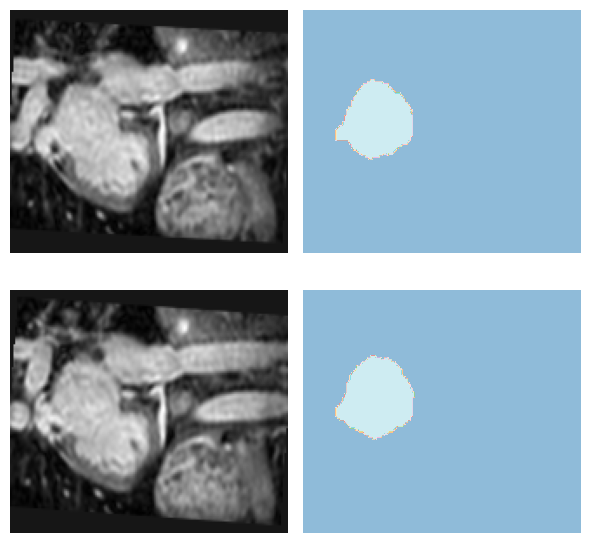

In [16]:
dls.show_batch(anatomical_plane=0, unique=True)

In [17]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(13, 3)

In [18]:
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

In [19]:
codes = np.unique(med_img_reader(df.label.tolist()[0]))
n_classes = len(codes)

In [20]:
codes, n_classes

(array([0., 1.], dtype=float32), 2)

In [21]:
model = UNet(dimensions=3, in_channels=1, out_channels=n_classes, 
             channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), 
             num_res_units=2)

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [22]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [23]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)

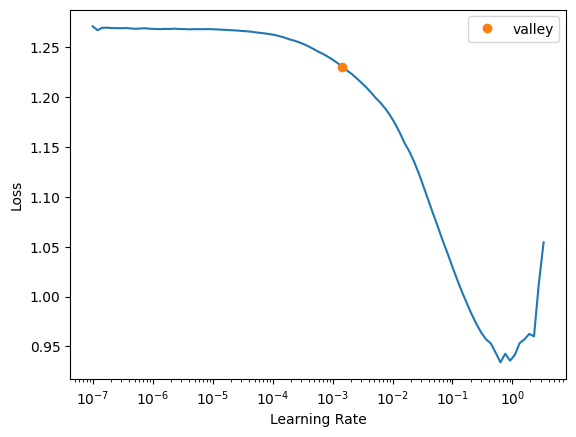

In [24]:
lr = learn.lr_find()#.to_fp16()

In [25]:
epochs = 5

In [26]:
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.254490,1.237245,0.011697,00:07
1,1.220452,1.167722,0.023441,00:07
2,1.186513,1.119269,0.045904,00:07
3,1.157233,1.081099,0.079307,00:07
4,1.132935,1.065604,0.094997,00:07


In [27]:
learn.save('baseline.Heart-model')

Path('models/baseline.Heart-model.pth')

In [28]:
test_dl = learn.dls.test_dl(df,with_labels=True)

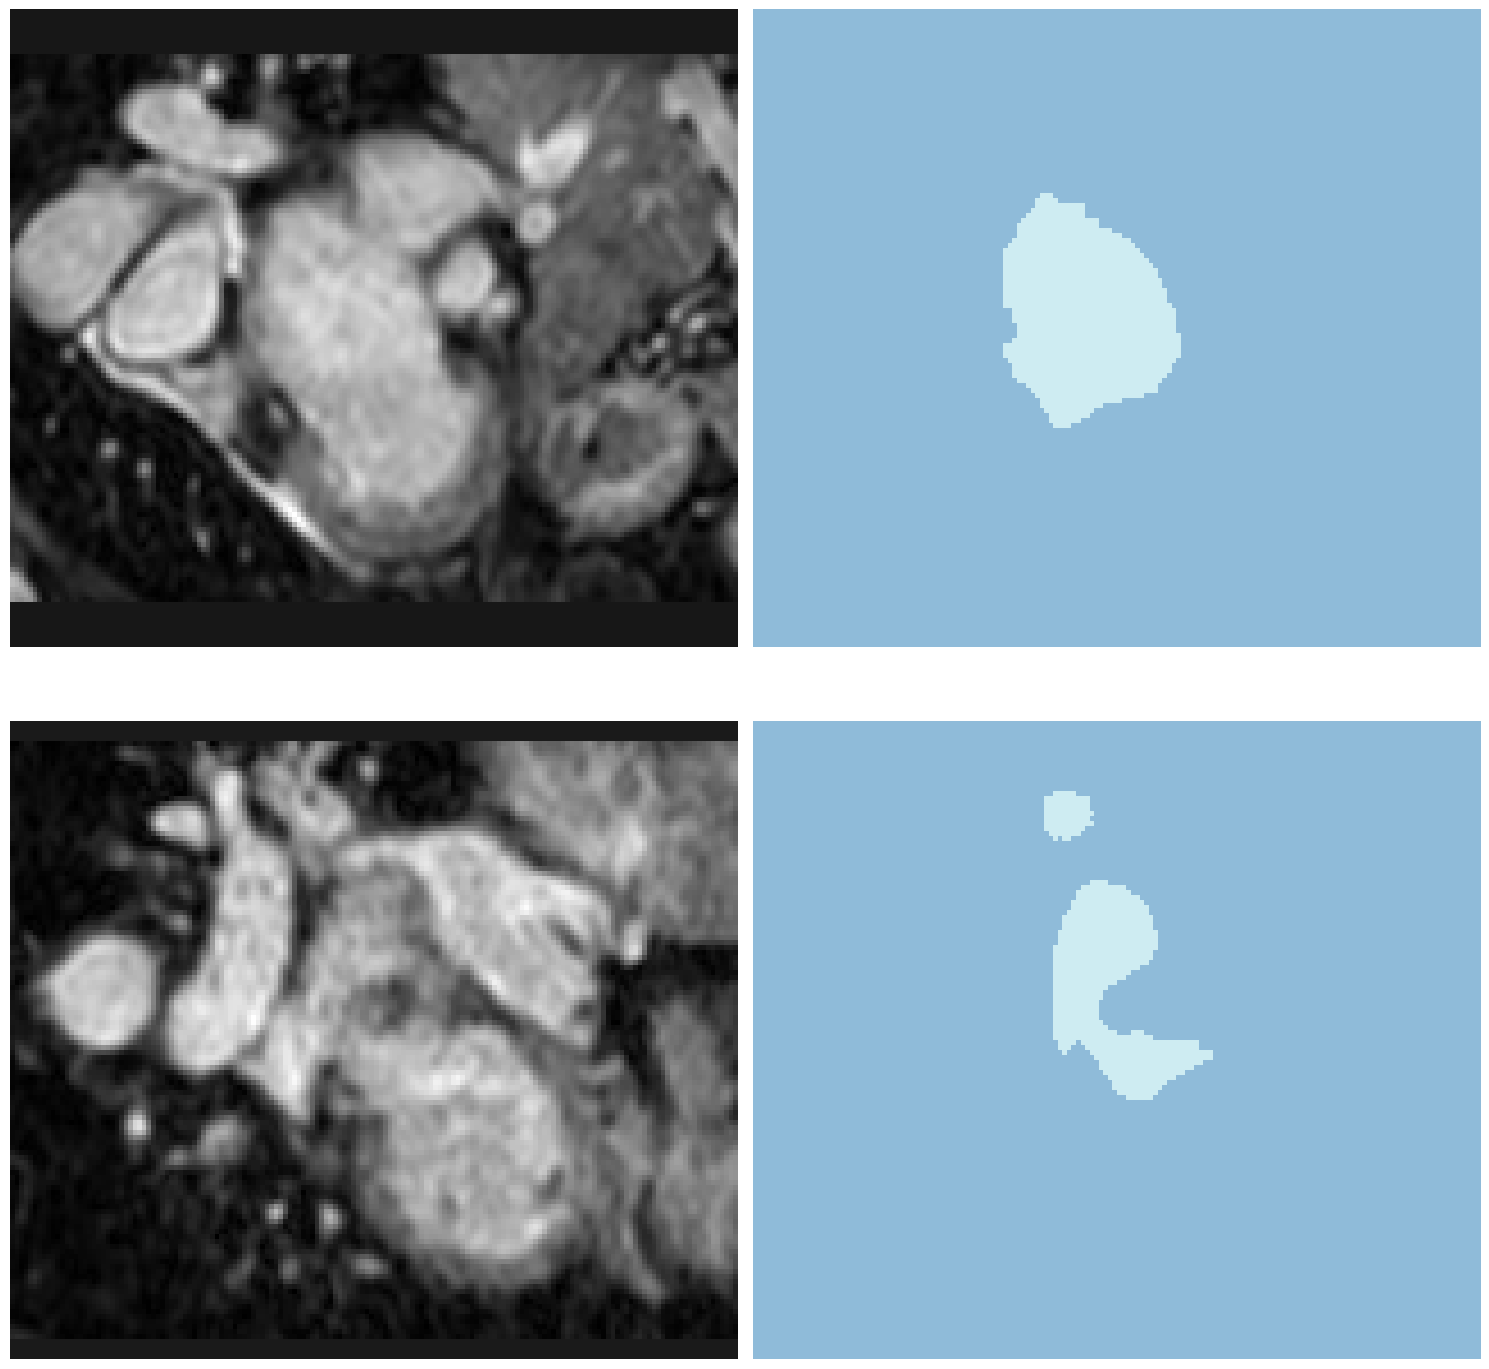

In [29]:
test_dl.show_batch(anatomical_plane=0, figsize=(15,15))

In [30]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([16, 2, 160, 160, 128]), torch.Size([16, 1, 160, 160, 128]))

In [31]:
multi_dice_score(pred_acts, labels)

tensor([0.1047])

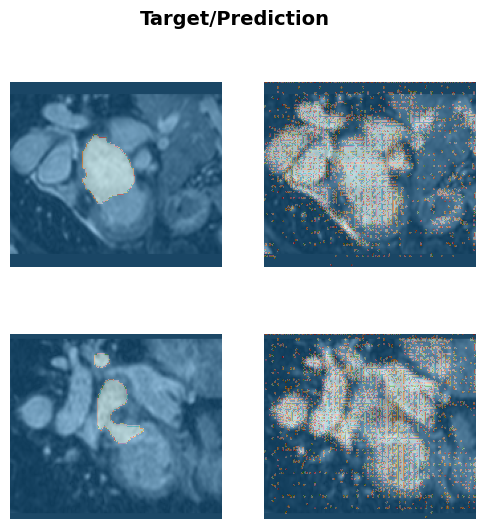

In [32]:
learn.show_results(anatomical_plane=0, dl=test_dl)

In [33]:
learn.export('baseline_heart_model.pkl')